In [1]:
import pandas as pd, textblob, string
pd.set_option('display.max_colwidth', -1) #To show the whole tweet field
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics,svm
import seaborn as pl

In [26]:
#Import Training and Testing Data
train = pd.read_csv('train.csv')
print("Training Set:"% train.columns, train.shape, len(train))
test = pd.read_csv('test_tweets.csv')
print("Test Set:"% test.columns, test.shape, len(test))
#Percentage of Positive/Negative
print("Positive: ", train.label.value_counts()[0]/len(train_cl)*100,"%")
print("Negative: ", train.label.value_counts()[1]/len(train_cl)*100,"%")

Training Set: (31962, 3) 31962
Test Set: (17197, 2) 17197
Positive:  83.45735868130633 %
Negative:  6.295807475218332 %


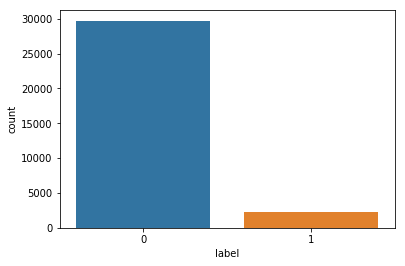

In [27]:
pl.countplot(train["label"])

In [28]:
#Remove Special Charactors
import re
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9/]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)    
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(letters_only)    
    sentence=[]
    for word in words:
        sentence.append(word)
        sentence.append(" ")
    words="".join(sentence).strip()    
    return words

In [29]:
nums = [0,len(train)]
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    clean_tweet_texts.append(tweet_cleaner(train['tweet'][i]))
nums = [0,len(test)]
test_tweet_texts = []
for i in range(nums[0],nums[1]):
    test_tweet_texts.append(tweet_cleaner(test['tweet'][i]))

train_clean = pd.DataFrame(clean_tweet_texts,columns=['tweet'])
train_clean['label'] = train.label
train_clean['id'] = train.id
test_clean = pd.DataFrame(test_tweet_texts,columns=['tweet'])
test_clean['id'] = test.id

In [30]:
train_clean[train_clean['label']==1].head()

,tweet,label,id
13,cnn calls michigan middle school build the wall chant tcot,1,14
14,no comment in australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins,1,15
17,retweet if you agree,1,18
23,lumpy says i am a prove it lumpy,1,24
34,it s unbelievable that in the st century we d need something like this again neverump xenophobia,1,35


In [46]:
train[train['label']==1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [32]:
# These mappings can get fairly large -- they're stored globally to
# save copying time.
#Reference
# (tuple of words) -> {dict: word -> number of times the word appears following the tuple}
# Example entry:
#    ('eyes', 'turned') => {'to': 2.0, 'from': 1.0}
# Used briefly while first constructing the normalized mapping
tempMapping = {}

# (tuple of words) -> {dict: word -> *normalized* number of times the word appears following the tuple}
# Example entry:
#    ('eyes', 'turned') => {'to': 0.66666666, 'from': 0.33333333}
mapping = {}

# Contains the set of words that can start sentences
starts = []

# We want to be able to compare words independent of their capitalization.
def fixCaps(word):
    # Ex: "FOO" -> "foo"
    if word.isupper() and word != "I":
        word = word.lower()
        # Ex: "LaTeX" => "Latex"
    elif word [0].isupper():
        word = word.lower().capitalize()
        # Ex: "wOOt" -> "woot"
    else:
        word = word.lower()
    return word

# Tuples can be hashed; lists can't.  We need hashable values for dict keys.
# This looks like a hack (and it is, a little) but in practice it doesn't
# affect processing time too negatively.
def toHashKey(lst):
    return tuple(lst)

# Returns the contents of the file, split into a list of words and
# (some) punctuation.
def wordlist(data):
    split_it = '. '.join([text for text in data])
    wordlist = [fixCaps(w) for w in re.findall(r"[\w']+|[.,!?;]", split_it)]    
    return wordlist

# Self-explanatory -- adds "word" to the "tempMapping" dict under "history".
# tempMapping (and mapping) both match each word to a list of possible next
# words.
# Given history = ["the", "rain", "in"] and word = "Spain", we add "Spain" to
# the entries for ["the", "rain", "in"], ["rain", "in"], and ["in"].
def addItemToTempMapping(history, word):
    global tempMapping
    while len(history) > 0:
        first = toHashKey(history)
        if first in tempMapping:
            if word in tempMapping[first]:
                tempMapping[first][word] += 1.0
            else:
                tempMapping[first][word] = 1.0
        else:
            tempMapping[first] = {}
            tempMapping[first][word] = 1.0
        history = history[1:]

# Building and normalizing the mapping.
def buildMapping(wordlist, markovLength):
    global tempMapping
    starts.append(wordlist [0])
    for i in range(1, len(wordlist) - 1):
        if i <= markovLength:
            history = wordlist[: i + 1]
        else:
            history = wordlist[i - markovLength + 1 : i + 1]
        follow = wordlist[i + 1]
        # if the last elt was a period, add the next word to the start list
        if history[-1] == "." and follow not in ".,!?;":
            starts.append(follow)
        addItemToTempMapping(history, follow)
    # Normalize the values in tempMapping, put them into mapping
    for first, followset in tempMapping.items():
        total = sum(followset.values())
        # Normalizing here:
        mapping[first] = dict([(k, v / total) for k, v in followset.items()])

# Returns the next word in the sentence (chosen randomly),
# given the previous ones.
def next(prevList):
    sum = 0.0
    retval = ""
    index = random.random()
    # Shorten prevList until it's in mapping
    while toHashKey(prevList) not in mapping:
        try:
            prevList.pop(0)
        except:
            prevList=random.choice(starts)
    # Get a random word from the mapping, given prevList
    for k, v in mapping[toHashKey(prevList)].items():
        sum += v
        if sum >= index and retval == "":
            retval = k
    return retval

def genSentence(markovLength):
    # Start with a random "starting word"
    curr = random.choice(starts)
    sent = curr.capitalize()
    prevList = [curr]
    # Keep adding words until we hit a period
    while (curr not in "."):
        curr = next(prevList)
        prevList.append(curr)        
        # if the prevList has gotten too long, trim it
        if len(prevList) > markovLength:
            prevList.pop(0)
        if (curr not in ".,!?;"):
            sent += " " # Add spaces between words (but not punctuation)
        sent += curr
    return sent

In [50]:
tempMapping

{('cnn', 'calls'): {'michigan': 2.0},
 ('calls',): {'michigan': 2.0,
  'me': 1.0,
  'her': 1.0,
  'for': 5.0,
  'an': 1.0,
  'americans': 2.0},
 ('cnn', 'calls', 'michigan'): {'middle': 1.0},
 ('calls', 'michigan'): {'middle': 2.0},
 ('michigan',): {'middle': 2.0},
 ('michigan', 'middle'): {'school': 2.0},
 ('middle',): {'school': 2.0},
 ('middle', 'school'): {'build': 2.0},
 ('school',): {'build': 2.0,
  'districts': 2.0,
  'board': 8.0,
  'i': 1.0,
  'game': 1.0,
  'texas': 1.0,
  'and': 1.0,
  'district': 1.0},
 ('school', 'build'): {'the': 2.0},
 ('build',): {'the': 2.0, 'our': 1.0, 'bridges': 1.0, 'walls': 1.0},
 ('build', 'the'): {'wall': 2.0},
 ('the',): {'wall': 4.0,
  'st': 3.0,
  'white': 16.0,
  'altright': 3.0,
  'smaller': 1.0,
  'trash': 1.0,
  'state': 1.0,
  'biggest': 2.0,
  'same': 13.0,
  'dying': 2.0,
  'light': 3.0,
  'nazi': 3.0,
  'pic': 1.0,
  'nazis': 2.0,
  'consequences': 1.0,
  'are': 51.0,
  'more': 6.0,
  'asians': 1.0,
  'africans': 1.0,
  'police': 3.0,


In [122]:
#extracting racist/sexist tweets
negativeTweets=train_clean[train_clean['label']==1]
newlyGeneratedTweets=pd.DataFrame()
#Repeat with the New Sentences for 3 times
for i in range(3):
    data = negativeTweets['tweet']
    markovLength = 2
    numberofsentences=data.size
    buildMapping(wordlist(data), markovLength)
    newTweets = []
    for i in range(numberofsentences):
        newTweet=genSentence(markovLength)
        # Sentence should have more than 10 chatachters
        if len(newTweet) > 15:
            newTweets.append(newTweet)
    d={'tweet':newTweets,'label':1}
    df=pd.DataFrame(data=d)
    newlyGeneratedTweets=newlyGeneratedTweets.append(df)
    newlyGeneratedTweets=newlyGeneratedTweets.reset_index()
    newlyGeneratedTweets=newlyGeneratedTweets.drop(['index'], axis=1)
    print(newlyGeneratedTweets.shape)

(2057, 2)
(4101, 2)
(6160, 2)


In [123]:
newlyGeneratedTweets.tail()

,tweet,label
6155,All the way through jo.,1
6156,Isn t white i m constantly let down by the perks offered to passengers of the impoance of families familycircus chri.,1
6157,Comment donation for tefugeeswelcome sucks.,1
6158,Australia and japanese whaling opkillingbay thecove shabbatshalom.,1
6159,Feminismiscancer feminismisterrorism feminismmuktbharat why malevote is ignored.,1


In [124]:
train_cl=train_clean.append(newlyGeneratedTweets)
#train_cl=train_cl.append(hateTweets)
train_cl=train_cl.drop(['id'], axis=1)
#Percentage of Positive/Negative
print("Positive: ", train_cl.label.value_counts()[0]/len(train_cl)*100,"%")
print("Negative: ", train_cl.label.value_counts()[1]/len(train_cl)*100,"%")

Positive:  77.9602329363622 %
Negative:  22.039767063637793 %


d:\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


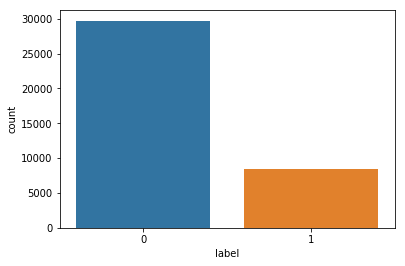

In [125]:
pl.countplot(train_cl["label"])

In [126]:
# Remove small tweets
train_cl=train_cl[train_cl['tweet'].str.len()>15]

In [127]:
x_train, x_test, y_train, y_test = train_test_split(train_cl['tweet'],train_cl['label'], test_size=0.33, random_state=42)

In [128]:
pr=Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                     ('clf', svm.LinearSVC(C=90.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-04, verbose=0))])

pr.fit(x_train, y_train)
predictions = pr.predict(x_test)
f1Score=metrics.f1_score(y_test,predictions)
print(f1Score)

0.9604049900560476


In [129]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
pr=Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                     ('clf', LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True, 
                                                intercept_scaling=1, max_iter=100, 
                                                multi_class='warn', n_jobs=None, penalty='l2', 
                                                solver='warn', tol=0.0001, verbose=0, 
                                                warm_start=False))])
pr.fit(x_train, y_train)
predictions = pr.predict(x_test)
f1Score=metrics.f1_score(y_test,predictions)
print(f1Score)

d:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9503365472075678


In [130]:
pr=Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                     ('clf', MultinomialNB(alpha=0.02))])
pr.fit(x_train, y_train)
predictions = pr.predict(x_test)
f1Score=metrics.f1_score(y_test,predictions)
print(f1Score)

0.9703465523401215


In [121]:
#Now working with Real challenge Data
train_x=train_clean['tweet']
valid_x=test_clean['tweet']
train_y=train_clean['label']

pr=Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                     ('clf', MultinomialNB(alpha=0.02))])
pr.fit(x_train, y_train)
predictions = pr.predict(valid_x)
d={'id':test['id'],'label':predictions}
df=pd.DataFrame(data=d)
df.to_csv("test_predictions_MultiNomialNB_Markov.csv", index=False)

In [80]:
'''#Now working with Real challenge Data
train_x=train_clean['tweet']
valid_x=test_clean['tweet']
train_y=train_clean['label']

pr=Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                     ('clf', svm.LinearSVC(C=90.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-04, verbose=0))])
#Scored 0.733834586466165
pr.fit(x_train, y_train)
predictions = pr.predict(valid_x)
d={'id':test['id'],'Tweet':valid_x,'label':predictions}
df=pd.DataFrame(data=d)
df.to_csv("test_predictions_LinearSVC_Markov.csv")'''